# LightGBM


In [12]:
import pandas as pd
import numpy as np

In [13]:
df = pd.read_csv("../data/forest_data.csv")
df.head()

,Area,Oxygen,Temperature,Humidity,Fire Occurrence
0,Kotagiri,5,19,52,1
1,Ladakh,8,26,59,1
2,Andaman,6,22,63,0
3,Jim,9,26,59,1
4,Silent,8,27,65,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Area             5000 non-null   object
 1   Oxygen           5000 non-null   int64 
 2   Temperature      5000 non-null   int64 
 3   Humidity         5000 non-null   int64 
 4   Fire Occurrence  5000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 195.4+ KB


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


def data_split(df, target):
    X, Y = df.drop(["Area", target], axis=1), df[target]
    return X, Y

In [16]:
x_full, y_full = data_split(df, "Fire Occurrence")

In [17]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
import optuna


def find_oof_score(oof, y_val):
    predictions = oof.argmax(axis=1)
    return roc_auc_score(y_val, predictions, average="macro")


def fit_cb(trial, xtr, ytr, xval, yval):
    params = {
        "boosting_type": "dart",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = LGBMClassifier(**params)

    model.fit(xtr, ytr)

    y_val_pred = model.predict_proba(xval)[:, 1]

    log = {
        "train ROC_AUC": roc_auc_score(ytr, model.predict_proba(xtr)[:, 1]),
        "valid ROC_AUC": roc_auc_score(yval, model.predict_proba(xval)[:, 1]),
    }

    return model, y_val_pred, log


def objective(trial):
    oof = np.zeros((x_full.shape[0], 2))

    for train_index, val_index in skf.split(x_full, y_full):
        x_train, x_val = x_full.iloc[train_index], x_full.iloc[val_index]
        y_train, y_val = y_full.iloc[train_index], y_full.iloc[val_index]
        m, y_val_pred, log = fit_cb(trial, x_train, y_train, x_val, y_val)

        oof = m.predict_proba(x_val)

    return find_oof_score(oof, y_val)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2023-07-02 18:22:16,699] A new study created in memory with name: no-name-4c6512b7-6ffe-45dd-ade5-3270f1501949


[LightGBM] [Warning] lambda_l1 is set=1.9465709867642835e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9465709867642835e-06
[LightGBM] [Warning] feature_fraction is set=0.42209024971843867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42209024971843867
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00021449028245709332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021449028245709332
[LightGBM] [Warning] bagging_fraction is set=0.46816852376658924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46816852376658924
[LightGBM] [Warning] lambda_l1 is set=1.9465709867642835e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9465709867642835e-06
[LightGBM] [Warning] feature_fraction is set=0.42209024971843867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42209024971843867
[LightG

[I 2023-07-02 18:22:17,322] Trial 0 finished with value: 0.8342147435897437 and parameters: {'lambda_l1': 1.9465709867642835e-06, 'lambda_l2': 0.00021449028245709332, 'num_leaves': 243, 'feature_fraction': 0.42209024971843867, 'bagging_fraction': 0.46816852376658924, 'bagging_freq': 3, 'min_child_samples': 82}. Best is trial 0 with value: 0.8342147435897437.


[LightGBM] [Warning] lambda_l1 is set=0.6263855226508094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6263855226508094
[LightGBM] [Warning] feature_fraction is set=0.7974638716891038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7974638716891038
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.0323041573056555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0323041573056555
[LightGBM] [Warning] bagging_fraction is set=0.9825763147852533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9825763147852533
[LightGBM] [Warning] lambda_l1 is set=0.6263855226508094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6263855226508094
[LightGBM] [Warning] feature_fraction is set=0.7974638716891038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7974638716891038
[LightGBM] [Warning] bagging_freq is 

[I 2023-07-02 18:22:17,693] Trial 1 finished with value: 0.828125 and parameters: {'lambda_l1': 0.6263855226508094, 'lambda_l2': 0.0323041573056555, 'num_leaves': 249, 'feature_fraction': 0.7974638716891038, 'bagging_fraction': 0.9825763147852533, 'bagging_freq': 2, 'min_child_samples': 62}. Best is trial 0 with value: 0.8342147435897437.


[LightGBM] [Warning] lambda_l1 is set=0.6263855226508094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6263855226508094
[LightGBM] [Warning] feature_fraction is set=0.7974638716891038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7974638716891038
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.0323041573056555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0323041573056555
[LightGBM] [Warning] bagging_fraction is set=0.9825763147852533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9825763147852533
[LightGBM] [Warning] lambda_l1 is set=0.6263855226508094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6263855226508094
[LightGBM] [Warning] feature_fraction is set=0.7974638716891038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7974638716891038
[LightGBM] [Warning] bagging_freq is 

[I 2023-07-02 18:22:18,119] Trial 2 finished with value: 0.8311698717948719 and parameters: {'lambda_l1': 0.09161094136192782, 'lambda_l2': 0.00534993068067263, 'num_leaves': 23, 'feature_fraction': 0.7974827135660878, 'bagging_fraction': 0.6189786372332954, 'bagging_freq': 1, 'min_child_samples': 63}. Best is trial 0 with value: 0.8342147435897437.


[LightGBM] [Warning] lambda_l1 is set=0.09161094136192782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09161094136192782
[LightGBM] [Warning] feature_fraction is set=0.7974827135660878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7974827135660878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.00534993068067263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00534993068067263
[LightGBM] [Warning] bagging_fraction is set=0.6189786372332954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6189786372332954
[LightGBM] [Warning] lambda_l1 is set=0.05736695002379244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05736695002379244
[LightGBM] [Warning] feature_fraction is set=0.6734034503681325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6734034503681325
[LightGBM] [Warning] bagging_fr

[I 2023-07-02 18:22:18,433] Trial 3 finished with value: 0.8307692307692308 and parameters: {'lambda_l1': 0.05736695002379244, 'lambda_l2': 1.7925375152808811, 'num_leaves': 116, 'feature_fraction': 0.6734034503681325, 'bagging_fraction': 0.5503866686076773, 'bagging_freq': 3, 'min_child_samples': 70}. Best is trial 0 with value: 0.8342147435897437.


[LightGBM] [Warning] lambda_l1 is set=0.05736695002379244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05736695002379244
[LightGBM] [Warning] feature_fraction is set=0.6734034503681325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6734034503681325
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7925375152808811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7925375152808811
[LightGBM] [Warning] bagging_fraction is set=0.5503866686076773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5503866686076773
[LightGBM] [Warning] lambda_l1 is set=0.05736695002379244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05736695002379244
[LightGBM] [Warning] feature_fraction is set=0.6734034503681325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6734034503681325
[LightGBM] [Warning] bagging_freq

[I 2023-07-02 18:22:18,689] Trial 4 finished with value: 0.8363782051282052 and parameters: {'lambda_l1': 0.29565780992440927, 'lambda_l2': 0.21599546643441445, 'num_leaves': 7, 'feature_fraction': 0.46659173023092576, 'bagging_fraction': 0.5966942458761022, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 4 with value: 0.8363782051282052.


[LightGBM] [Warning] lambda_l1 is set=0.29565780992440927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29565780992440927
[LightGBM] [Warning] feature_fraction is set=0.46659173023092576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46659173023092576
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.21599546643441445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21599546643441445
[LightGBM] [Warning] bagging_fraction is set=0.5966942458761022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5966942458761022
[LightGBM] [Warning] lambda_l1 is set=0.29565780992440927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29565780992440927
[LightGBM] [Warning] feature_fraction is set=0.46659173023092576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46659173023092576
[LightGBM] [Warning] baggin

[I 2023-07-02 18:22:19,040] Trial 5 finished with value: 0.835176282051282 and parameters: {'lambda_l1': 0.028668130084431555, 'lambda_l2': 0.09399807290378354, 'num_leaves': 251, 'feature_fraction': 0.8352123020605677, 'bagging_fraction': 0.5779449538977509, 'bagging_freq': 2, 'min_child_samples': 99}. Best is trial 4 with value: 0.8363782051282052.


[LightGBM] [Warning] lambda_l1 is set=9.631991830520628e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.631991830520628e-06
[LightGBM] [Warning] feature_fraction is set=0.5808322477997985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808322477997985
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.875401436457358e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.875401436457358e-08
[LightGBM] [Warning] bagging_fraction is set=0.8288226369379454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8288226369379454
[LightGBM] [Warning] lambda_l1 is set=9.631991830520628e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.631991830520628e-06
[LightGBM] [Warning] feature_fraction is set=0.5808322477997985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808322477997985
[LightGBM] [Warning

[I 2023-07-02 18:22:19,516] Trial 6 finished with value: 0.8298878205128205 and parameters: {'lambda_l1': 9.631991830520628e-06, 'lambda_l2': 9.875401436457358e-08, 'num_leaves': 34, 'feature_fraction': 0.5808322477997985, 'bagging_fraction': 0.8288226369379454, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 4 with value: 0.8363782051282052.


[LightGBM] [Warning] lambda_l1 is set=9.631991830520628e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.631991830520628e-06
[LightGBM] [Warning] feature_fraction is set=0.5808322477997985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808322477997985
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.875401436457358e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.875401436457358e-08
[LightGBM] [Warning] bagging_fraction is set=0.8288226369379454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8288226369379454
[LightGBM] [Warning] lambda_l1 is set=9.631991830520628e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.631991830520628e-06
[LightGBM] [Warning] feature_fraction is set=0.5808322477997985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808322477997985
[LightGBM] [Warning

[I 2023-07-02 18:22:20,130] Trial 7 finished with value: 0.8282051282051284 and parameters: {'lambda_l1': 0.004965217928477565, 'lambda_l2': 4.07024285105059e-07, 'num_leaves': 128, 'feature_fraction': 0.5796716372226467, 'bagging_fraction': 0.7322038479815565, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 4 with value: 0.8363782051282052.


[LightGBM] [Warning] lambda_l1 is set=1.5560068473472995e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5560068473472995e-08
[LightGBM] [Warning] feature_fraction is set=0.6620536000376602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6620536000376602
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.446354247732267e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.446354247732267e-08
[LightGBM] [Warning] bagging_fraction is set=0.6293779251786753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6293779251786753
[LightGBM] [Warning] lambda_l1 is set=1.5560068473472995e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5560068473472995e-08
[LightGBM] [Warning] feature_fraction is set=0.6620536000376602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6620536000376602
[LightGBM] [War

[I 2023-07-02 18:22:20,816] Trial 8 finished with value: 0.8346153846153846 and parameters: {'lambda_l1': 1.5560068473472995e-08, 'lambda_l2': 8.446354247732267e-08, 'num_leaves': 225, 'feature_fraction': 0.6620536000376602, 'bagging_fraction': 0.6293779251786753, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 4 with value: 0.8363782051282052.


[LightGBM] [Warning] lambda_l1 is set=1.5560068473472995e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5560068473472995e-08
[LightGBM] [Warning] feature_fraction is set=0.6620536000376602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6620536000376602
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.446354247732267e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.446354247732267e-08
[LightGBM] [Warning] bagging_fraction is set=0.6293779251786753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6293779251786753
[LightGBM] [Warning] lambda_l1 is set=9.303291299312827e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.303291299312827e-07
[LightGBM] [Warning] feature_fraction is set=0.5729702016292402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5729702016292402
[LightGBM] [Warni

[I 2023-07-02 18:22:21,266] Trial 9 finished with value: 0.831650641025641 and parameters: {'lambda_l1': 9.303291299312827e-07, 'lambda_l2': 4.393881535863541e-08, 'num_leaves': 120, 'feature_fraction': 0.5729702016292402, 'bagging_fraction': 0.4009391820764553, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 4 with value: 0.8363782051282052.


[LightGBM] [Warning] lambda_l1 is set=9.303291299312827e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.303291299312827e-07
[LightGBM] [Warning] feature_fraction is set=0.5729702016292402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5729702016292402
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.393881535863541e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.393881535863541e-08
[LightGBM] [Warning] bagging_fraction is set=0.4009391820764553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4009391820764553
[LightGBM] [Warning] lambda_l1 is set=8.707481235892123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.707481235892123
[LightGBM] [Warning] feature_fraction is set=0.43416397700384013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43416397700384013
[LightGBM] [Warning] bagg

[I 2023-07-02 18:22:21,477] Trial 10 finished with value: 0.8342147435897437 and parameters: {'lambda_l1': 8.707481235892123, 'lambda_l2': 6.360808682373168, 'num_leaves': 52, 'feature_fraction': 0.43416397700384013, 'bagging_fraction': 0.7385074614357098, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 4 with value: 0.8363782051282052.


[LightGBM] [Warning] lambda_l1 is set=8.707481235892123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.707481235892123
[LightGBM] [Warning] feature_fraction is set=0.43416397700384013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43416397700384013
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.360808682373168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.360808682373168
[LightGBM] [Warning] bagging_fraction is set=0.7385074614357098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385074614357098
[LightGBM] [Warning] lambda_l1 is set=8.707481235892123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.707481235892123
[LightGBM] [Warning] feature_fraction is set=0.43416397700384013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43416397700384013
[LightGBM] [Warning] bagging_freq is se

[I 2023-07-02 18:22:21,880] Trial 11 finished with value: 0.836378205128205 and parameters: {'lambda_l1': 0.0018087364803228568, 'lambda_l2': 0.11119144086677123, 'num_leaves': 202, 'feature_fraction': 0.9752713006312089, 'bagging_fraction': 0.5428317667562814, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 4 with value: 0.8363782051282052.


[LightGBM] [Warning] lambda_l1 is set=0.0018087364803228568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018087364803228568
[LightGBM] [Warning] feature_fraction is set=0.9752713006312089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9752713006312089
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.11119144086677123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11119144086677123
[LightGBM] [Warning] bagging_fraction is set=0.5428317667562814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5428317667562814
[LightGBM] [Warning] lambda_l1 is set=0.0004593977386136424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004593977386136424
[LightGBM] [Warning] feature_fraction is set=0.9825560777513909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9825560777513909
[LightGBM] [Warning] ba

[I 2023-07-02 18:22:23,107] Trial 12 finished with value: 0.8359775641025642 and parameters: {'lambda_l1': 0.0004593977386136424, 'lambda_l2': 0.2591629751505087, 'num_leaves': 192, 'feature_fraction': 0.9825560777513909, 'bagging_fraction': 0.5161491567934741, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 4 with value: 0.8363782051282052.


[LightGBM] [Warning] lambda_l1 is set=0.0013062846115435684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013062846115435684
[LightGBM] [Warning] feature_fraction is set=0.9676426017737223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9676426017737223
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=9.785216372229407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.785216372229407
[LightGBM] [Warning] bagging_fraction is set=0.4742127701738099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4742127701738099
[LightGBM] [Warning] lambda_l1 is set=0.0013062846115435684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013062846115435684
[LightGBM] [Warning] feature_fraction is set=0.9676426017737223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9676426017737223
[LightGBM] [Warning] baggin

[I 2023-07-02 18:22:23,397] Trial 13 finished with value: 0.8414262820512819 and parameters: {'lambda_l1': 0.0013062846115435684, 'lambda_l2': 9.785216372229407, 'num_leaves': 180, 'feature_fraction': 0.9676426017737223, 'bagging_fraction': 0.4742127701738099, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=0.0013062846115435684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013062846115435684
[LightGBM] [Warning] feature_fraction is set=0.9676426017737223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9676426017737223
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=9.785216372229407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.785216372229407
[LightGBM] [Warning] bagging_fraction is set=0.4742127701738099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4742127701738099
[LightGBM] [Warning] lambda_l1 is set=0.00030605505669700994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00030605505669700994
[LightGBM] [Warning] feature_fraction is set=0.8944814061979478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8944814061979478
[LightGBM] [Warning] bagg

[I 2023-07-02 18:22:23,723] Trial 14 finished with value: 0.8394230769230768 and parameters: {'lambda_l1': 0.00030605505669700994, 'lambda_l2': 6.621035115320303, 'num_leaves': 165, 'feature_fraction': 0.8944814061979478, 'bagging_fraction': 0.4292370818330179, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=0.00030605505669700994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00030605505669700994
[LightGBM] [Warning] feature_fraction is set=0.8944814061979478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8944814061979478
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.621035115320303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.621035115320303
[LightGBM] [Warning] bagging_fraction is set=0.4292370818330179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4292370818330179
[LightGBM] [Warning] lambda_l1 is set=0.00030605505669700994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00030605505669700994
[LightGBM] [Warning] feature_fraction is set=0.8944814061979478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8944814061979478
[LightGBM] [Warning] ba

[I 2023-07-02 18:22:24,050] Trial 15 finished with value: 0.8401442307692308 and parameters: {'lambda_l1': 7.533891673817333e-05, 'lambda_l2': 6.0448560648610465, 'num_leaves': 167, 'feature_fraction': 0.8969375613553165, 'bagging_fraction': 0.40800676563303007, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=8.009567464599042e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.009567464599042e-05
[LightGBM] [Warning] feature_fraction is set=0.9090505832150952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9090505832150952
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.57121737219187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57121737219187
[LightGBM] [Warning] bagging_fraction is set=0.4699921243460477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4699921243460477
[LightGBM] [Warning] lambda_l1 is set=8.009567464599042e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.009567464599042e-05
[LightGBM] [Warning] feature_fraction is set=0.9090505832150952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9090505832150952
[LightGBM] [Warning] bagging_

[I 2023-07-02 18:22:24,356] Trial 16 finished with value: 0.8381410256410258 and parameters: {'lambda_l1': 8.009567464599042e-05, 'lambda_l2': 8.57121737219187, 'num_leaves': 166, 'feature_fraction': 0.9090505832150952, 'bagging_fraction': 0.4699921243460477, 'bagging_freq': 7, 'min_child_samples': 74}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=8.009567464599042e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.009567464599042e-05
[LightGBM] [Warning] feature_fraction is set=0.9090505832150952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9090505832150952
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.57121737219187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57121737219187
[LightGBM] [Warning] bagging_fraction is set=0.4699921243460477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4699921243460477
[LightGBM] [Warning] lambda_l1 is set=8.17442737109718e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.17442737109718e-05
[LightGBM] [Warning] feature_fraction is set=0.9910976818120318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9910976818120318
[LightGBM] [Warning] bagging_fr

[I 2023-07-02 18:22:24,706] Trial 17 finished with value: 0.8331730769230768 and parameters: {'lambda_l1': 8.17442737109718e-05, 'lambda_l2': 1.078879665664962, 'num_leaves': 83, 'feature_fraction': 0.9910976818120318, 'bagging_fraction': 0.40804406738269366, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=8.17442737109718e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.17442737109718e-05
[LightGBM] [Warning] feature_fraction is set=0.9910976818120318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9910976818120318
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.078879665664962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.078879665664962
[LightGBM] [Warning] bagging_fraction is set=0.40804406738269366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40804406738269366
[LightGBM] [Warning] lambda_l1 is set=8.17442737109718e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.17442737109718e-05
[LightGBM] [Warning] feature_fraction is set=0.9910976818120318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9910976818120318
[LightGBM] [Warning] bagging_

[I 2023-07-02 18:22:25,392] Trial 18 finished with value: 0.8282051282051281 and parameters: {'lambda_l1': 0.004944339217400274, 'lambda_l2': 0.0031719258549120014, 'num_leaves': 161, 'feature_fraction': 0.9002517268008329, 'bagging_fraction': 0.48558428527477143, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=0.004944339217400274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004944339217400274
[LightGBM] [Warning] feature_fraction is set=0.9002517268008329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002517268008329
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0031719258549120014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0031719258549120014
[LightGBM] [Warning] bagging_fraction is set=0.48558428527477143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48558428527477143
[LightGBM] [Warning] lambda_l1 is set=1.7424349724108168e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7424349724108168e-05
[LightGBM] [Warning] feature_fraction is set=0.7439893275376619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7439893275376619
[LightGBM] [Warni

[I 2023-07-02 18:22:25,795] Trial 19 finished with value: 0.8336538461538462 and parameters: {'lambda_l1': 1.7424349724108168e-05, 'lambda_l2': 0.7037354818862943, 'num_leaves': 85, 'feature_fraction': 0.7439893275376619, 'bagging_fraction': 0.4888358490747864, 'bagging_freq': 4, 'min_child_samples': 44}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=1.7424349724108168e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7424349724108168e-05
[LightGBM] [Warning] feature_fraction is set=0.7439893275376619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7439893275376619
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.7037354818862943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7037354818862943
[LightGBM] [Warning] bagging_fraction is set=0.4888358490747864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4888358490747864
[LightGBM] [Warning] lambda_l1 is set=0.0014487955991773246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014487955991773246
[LightGBM] [Warning] feature_fraction is set=0.9365790001735775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9365790001735775
[LightGBM] [Warning] ba

[I 2023-07-02 18:22:26,212] Trial 20 finished with value: 0.8391826923076924 and parameters: {'lambda_l1': 0.0014487955991773246, 'lambda_l2': 1.0367867606567178, 'num_leaves': 146, 'feature_fraction': 0.9365790001735775, 'bagging_fraction': 0.4491980723810127, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=0.0001424436277960039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001424436277960039
[LightGBM] [Warning] feature_fraction is set=0.8653895359169564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8653895359169564
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.129578605685671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.129578605685671
[LightGBM] [Warning] bagging_fraction is set=0.409557004507903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.409557004507903
[LightGBM] [Warning] lambda_l1 is set=0.0001424436277960039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001424436277960039
[LightGBM] [Warning] feature_fraction is set=0.8653895359169564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8653895359169564
[LightGBM] [Warning] bagging_

[I 2023-07-02 18:22:26,540] Trial 21 finished with value: 0.8403846153846153 and parameters: {'lambda_l1': 0.0001424436277960039, 'lambda_l2': 7.129578605685671, 'num_leaves': 189, 'feature_fraction': 0.8653895359169564, 'bagging_fraction': 0.409557004507903, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=0.0001424436277960039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001424436277960039
[LightGBM] [Warning] feature_fraction is set=0.8653895359169564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8653895359169564
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.129578605685671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.129578605685671
[LightGBM] [Warning] bagging_fraction is set=0.409557004507903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.409557004507903
[LightGBM] [Warning] lambda_l1 is set=0.0002724406030809483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002724406030809483
[LightGBM] [Warning] feature_fraction is set=0.8567497726157516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8567497726157516
[LightGBM] [Warning] bagging_

[I 2023-07-02 18:22:26,850] Trial 22 finished with value: 0.8362179487179487 and parameters: {'lambda_l1': 0.0002724406030809483, 'lambda_l2': 7.299393985415273, 'num_leaves': 200, 'feature_fraction': 0.8567497726157516, 'bagging_fraction': 0.410471758490616, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=0.0002724406030809483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002724406030809483
[LightGBM] [Warning] feature_fraction is set=0.8567497726157516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8567497726157516
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.299393985415273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.299393985415273
[LightGBM] [Warning] bagging_fraction is set=0.410471758490616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.410471758490616
[LightGBM] [Warning] lambda_l1 is set=0.0002724406030809483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002724406030809483
[LightGBM] [Warning] feature_fraction is set=0.8567497726157516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8567497726157516
[LightGBM] [Warning] bagging_

[I 2023-07-02 18:22:27,238] Trial 23 finished with value: 0.8382211538461538 and parameters: {'lambda_l1': 4.8832319761090594e-05, 'lambda_l2': 2.7020228427144355, 'num_leaves': 187, 'feature_fraction': 0.9405419716026407, 'bagging_fraction': 0.48611791731922677, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=4.8832319761090594e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8832319761090594e-05
[LightGBM] [Warning] feature_fraction is set=0.9405419716026407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9405419716026407
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.7020228427144355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7020228427144355
[LightGBM] [Warning] bagging_fraction is set=0.48611791731922677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48611791731922677
[LightGBM] [Warning] lambda_l1 is set=0.009264406723218254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009264406723218254
[LightGBM] [Warning] feature_fraction is set=0.8645155771649465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8645155771649465
[LightGBM] [Warning] ba

[I 2023-07-02 18:22:27,634] Trial 24 finished with value: 0.8311698717948718 and parameters: {'lambda_l1': 0.009264406723218254, 'lambda_l2': 9.974560572360456, 'num_leaves': 221, 'feature_fraction': 0.8645155771649465, 'bagging_fraction': 0.5253234454666565, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=0.0007810130040572134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007810130040572134
[LightGBM] [Warning] feature_fraction is set=0.945339781176161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945339781176161
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.7455617710461794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7455617710461794
[LightGBM] [Warning] bagging_fraction is set=0.4405950566554413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4405950566554413
[LightGBM] [Warning] lambda_l1 is set=0.0007810130040572134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007810130040572134
[LightGBM] [Warning] feature_fraction is set=0.945339781176161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945339781176161
[LightGBM] [Warning] bagging_

[I 2023-07-02 18:22:27,972] Trial 25 finished with value: 0.8411858974358974 and parameters: {'lambda_l1': 0.0007810130040572134, 'lambda_l2': 0.7455617710461794, 'num_leaves': 142, 'feature_fraction': 0.945339781176161, 'bagging_fraction': 0.4405950566554413, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=0.0007810130040572134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007810130040572134
[LightGBM] [Warning] feature_fraction is set=0.945339781176161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945339781176161
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.7455617710461794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7455617710461794
[LightGBM] [Warning] bagging_fraction is set=0.4405950566554413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4405950566554413
[LightGBM] [Warning] lambda_l1 is set=0.0004544915850343378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004544915850343378
[LightGBM] [Warning] feature_fraction is set=0.9995011222537744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995011222537744
[LightGBM] [Warning] baggin

[I 2023-07-02 18:22:28,374] Trial 26 finished with value: 0.838301282051282 and parameters: {'lambda_l1': 0.0004544915850343378, 'lambda_l2': 0.5743301881360825, 'num_leaves': 142, 'feature_fraction': 0.9995011222537744, 'bagging_fraction': 0.5122892097280826, 'bagging_freq': 4, 'min_child_samples': 84}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=0.0019606478428812416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019606478428812416
[LightGBM] [Warning] feature_fraction is set=0.9474215279212052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9474215279212052
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.229977665692001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.229977665692001
[LightGBM] [Warning] bagging_fraction is set=0.46153464098471453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46153464098471453
[LightGBM] [Warning] lambda_l1 is set=0.0019606478428812416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019606478428812416
[LightGBM] [Warning] feature_fraction is set=0.9474215279212052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9474215279212052
[LightGBM] [Warning] bagg

[I 2023-07-02 18:22:28,680] Trial 27 finished with value: 0.8374999999999999 and parameters: {'lambda_l1': 0.0019606478428812416, 'lambda_l2': 1.229977665692001, 'num_leaves': 98, 'feature_fraction': 0.9474215279212052, 'bagging_fraction': 0.46153464098471453, 'bagging_freq': 5, 'min_child_samples': 99}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=0.0019606478428812416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019606478428812416
[LightGBM] [Warning] feature_fraction is set=0.9474215279212052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9474215279212052
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.229977665692001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.229977665692001
[LightGBM] [Warning] bagging_fraction is set=0.46153464098471453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46153464098471453
[LightGBM] [Warning] lambda_l1 is set=0.011786946769445866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011786946769445866
[LightGBM] [Warning] feature_fraction is set=0.9482225345309397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482225345309397
[LightGBM] [Warning] baggin

[I 2023-07-02 18:22:29,040] Trial 28 finished with value: 0.838301282051282 and parameters: {'lambda_l1': 0.011786946769445866, 'lambda_l2': 0.04081866702169301, 'num_leaves': 222, 'feature_fraction': 0.9482225345309397, 'bagging_fraction': 0.445355112798906, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=0.011786946769445866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011786946769445866
[LightGBM] [Warning] feature_fraction is set=0.9482225345309397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482225345309397
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.04081866702169301, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04081866702169301
[LightGBM] [Warning] bagging_fraction is set=0.445355112798906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.445355112798906
[LightGBM] [Warning] lambda_l1 is set=0.011786946769445866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011786946769445866
[LightGBM] [Warning] feature_fraction is set=0.9482225345309397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482225345309397
[LightGBM] [Warning] bagging_

[I 2023-07-02 18:22:29,401] Trial 29 finished with value: 0.838301282051282 and parameters: {'lambda_l1': 7.288426001933786e-06, 'lambda_l2': 0.0001828134028632591, 'num_leaves': 181, 'feature_fraction': 0.8363425712727285, 'bagging_fraction': 0.45719971298676265, 'bagging_freq': 4, 'min_child_samples': 86}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=7.288426001933786e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.288426001933786e-06
[LightGBM] [Warning] feature_fraction is set=0.8363425712727285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8363425712727285
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0001828134028632591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001828134028632591
[LightGBM] [Warning] bagging_fraction is set=0.45719971298676265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45719971298676265
[LightGBM] [Warning] lambda_l1 is set=2.186647270996009e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.186647270996009e-06
[LightGBM] [Warning] feature_fraction is set=0.9195048801928385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9195048801928385
[LightGBM] [Warni

[I 2023-07-02 18:22:29,762] Trial 30 finished with value: 0.8362980769230769 and parameters: {'lambda_l1': 2.186647270996009e-06, 'lambda_l2': 0.3330378090493565, 'num_leaves': 144, 'feature_fraction': 0.9195048801928385, 'bagging_fraction': 0.5674313528404094, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 13 with value: 0.8414262820512819.


[LightGBM] [Warning] lambda_l1 is set=2.186647270996009e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.186647270996009e-06
[LightGBM] [Warning] feature_fraction is set=0.9195048801928385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9195048801928385
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.3330378090493565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3330378090493565
[LightGBM] [Warning] bagging_fraction is set=0.5674313528404094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5674313528404094
[LightGBM] [Warning] lambda_l1 is set=2.186647270996009e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.186647270996009e-06
[LightGBM] [Warning] feature_fraction is set=0.9195048801928385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9195048801928385
[LightGBM] [Warning] bagg

[I 2023-07-02 18:22:30,072] Trial 31 finished with value: 0.8452724358974358 and parameters: {'lambda_l1': 0.0009458753945140191, 'lambda_l2': 2.9217684480345176, 'num_leaves': 173, 'feature_fraction': 0.8852633382081532, 'bagging_fraction': 0.40369258393108254, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.0009458753945140191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009458753945140191
[LightGBM] [Warning] feature_fraction is set=0.8852633382081532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8852633382081532
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.9217684480345176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9217684480345176
[LightGBM] [Warning] bagging_fraction is set=0.40369258393108254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40369258393108254
[LightGBM] [Warning] lambda_l1 is set=0.0014077077699185766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014077077699185766
[LightGBM] [Warning] feature_fraction is set=0.9601360609631086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9601360609631086
[LightGBM] [Warning] ba

[I 2023-07-02 18:22:30,426] Trial 32 finished with value: 0.8423878205128206 and parameters: {'lambda_l1': 0.0014077077699185766, 'lambda_l2': 2.5241023461442476, 'num_leaves': 211, 'feature_fraction': 0.9601360609631086, 'bagging_fraction': 0.43126352650807576, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.0014077077699185766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014077077699185766
[LightGBM] [Warning] feature_fraction is set=0.9601360609631086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9601360609631086
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.5241023461442476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5241023461442476
[LightGBM] [Warning] bagging_fraction is set=0.43126352650807576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43126352650807576
[LightGBM] [Warning] lambda_l1 is set=0.0014077077699185766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014077077699185766
[LightGBM] [Warning] feature_fraction is set=0.9601360609631086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9601360609631086
[LightGBM] [Warning] ba

[I 2023-07-02 18:22:30,756] Trial 33 finished with value: 0.8412660256410256 and parameters: {'lambda_l1': 0.0013881703331041306, 'lambda_l2': 1.8660843565725849, 'num_leaves': 217, 'feature_fraction': 0.9499674595886036, 'bagging_fraction': 0.44803418201433864, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.0013881703331041306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013881703331041306
[LightGBM] [Warning] feature_fraction is set=0.9499674595886036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9499674595886036
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.8660843565725849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8660843565725849
[LightGBM] [Warning] bagging_fraction is set=0.44803418201433864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44803418201433864
[LightGBM] [Warning] lambda_l1 is set=0.0027750100906199196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027750100906199196
[LightGBM] [Warning] feature_fraction is set=0.9785040734865056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9785040734865056
[LightGBM] [Warning] ba

[I 2023-07-02 18:22:31,100] Trial 34 finished with value: 0.8403846153846153 and parameters: {'lambda_l1': 0.0027750100906199196, 'lambda_l2': 2.3021741619836105, 'num_leaves': 234, 'feature_fraction': 0.9785040734865056, 'bagging_fraction': 0.4981390613098301, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.0027750100906199196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027750100906199196
[LightGBM] [Warning] feature_fraction is set=0.9785040734865056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9785040734865056
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.3021741619836105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3021741619836105
[LightGBM] [Warning] bagging_fraction is set=0.4981390613098301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4981390613098301
[LightGBM] [Warning] lambda_l1 is set=0.0027750100906199196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027750100906199196
[LightGBM] [Warning] feature_fraction is set=0.9785040734865056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9785040734865056
[LightGBM] [Warning] bagg

[I 2023-07-02 18:22:31,545] Trial 35 finished with value: 0.8360576923076923 and parameters: {'lambda_l1': 0.01923446340760606, 'lambda_l2': 0.019388424082922368, 'num_leaves': 206, 'feature_fraction': 0.8069895953422113, 'bagging_fraction': 0.4468950394748542, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.01923446340760606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01923446340760606
[LightGBM] [Warning] feature_fraction is set=0.8069895953422113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8069895953422113
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.019388424082922368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019388424082922368
[LightGBM] [Warning] bagging_fraction is set=0.4468950394748542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4468950394748542
[LightGBM] [Warning] lambda_l1 is set=0.01923446340760606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01923446340760606
[LightGBM] [Warning] feature_fraction is set=0.8069895953422113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8069895953422113
[LightGBM] [Warning] bagging_

[I 2023-07-02 18:22:31,956] Trial 36 finished with value: 0.8391025641025642 and parameters: {'lambda_l1': 0.02705861819281889, 'lambda_l2': 0.2472700417354713, 'num_leaves': 239, 'feature_fraction': 0.9628405748118931, 'bagging_fraction': 0.5156951935134163, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.02705861819281889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02705861819281889
[LightGBM] [Warning] feature_fraction is set=0.9628405748118931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9628405748118931
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.2472700417354713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2472700417354713
[LightGBM] [Warning] bagging_fraction is set=0.5156951935134163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5156951935134163
[LightGBM] [Warning] lambda_l1 is set=0.0008940657200824688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008940657200824688
[LightGBM] [Warning] feature_fraction is set=0.9996325362367464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996325362367464
[LightGBM] [Warning] bagging_

[I 2023-07-02 18:22:32,363] Trial 37 finished with value: 0.8374198717948718 and parameters: {'lambda_l1': 0.0008940657200824688, 'lambda_l2': 2.372830621766276, 'num_leaves': 212, 'feature_fraction': 0.9996325362367464, 'bagging_fraction': 0.5516440138973907, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.09637070516759122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09637070516759122
[LightGBM] [Warning] feature_fraction is set=0.9241321145685856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9241321145685856
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.09091167564007412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09091167564007412
[LightGBM] [Warning] bagging_fraction is set=0.4679409563707631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4679409563707631
[LightGBM] [Warning] lambda_l1 is set=0.09637070516759122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09637070516759122
[LightGBM] [Warning] feature_fraction is set=0.9241321145685856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9241321145685856
[LightGBM] [Warning] bagging_fr

[I 2023-07-02 18:22:32,709] Trial 38 finished with value: 0.8393429487179487 and parameters: {'lambda_l1': 0.09637070516759122, 'lambda_l2': 0.09091167564007412, 'num_leaves': 180, 'feature_fraction': 0.9241321145685856, 'bagging_fraction': 0.4679409563707631, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.09637070516759122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09637070516759122
[LightGBM] [Warning] feature_fraction is set=0.9241321145685856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9241321145685856
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.09091167564007412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09091167564007412
[LightGBM] [Warning] bagging_fraction is set=0.4679409563707631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4679409563707631
[LightGBM] [Warning] lambda_l1 is set=0.0042676119647380205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0042676119647380205
[LightGBM] [Warning] feature_fraction is set=0.8797712423115982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8797712423115982
[LightGBM] [Warning] baggin

[I 2023-07-02 18:22:33,112] Trial 39 finished with value: 0.8371794871794872 and parameters: {'lambda_l1': 0.0042676119647380205, 'lambda_l2': 2.1897483750882545, 'num_leaves': 244, 'feature_fraction': 0.8797712423115982, 'bagging_fraction': 0.6022327801995937, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.06265480727726606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06265480727726606
[LightGBM] [Warning] feature_fraction is set=0.9181270085295059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9181270085295059
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.4844609851167957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4844609851167957
[LightGBM] [Warning] bagging_fraction is set=0.5342573906388091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5342573906388091
[LightGBM] [Warning] lambda_l1 is set=0.06265480727726606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06265480727726606
[LightGBM] [Warning] feature_fraction is set=0.9181270085295059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9181270085295059
[LightGBM] [Warning] bagging_freq

[I 2023-07-02 18:22:33,484] Trial 40 finished with value: 0.8349358974358975 and parameters: {'lambda_l1': 0.06265480727726606, 'lambda_l2': 0.4844609851167957, 'num_leaves': 213, 'feature_fraction': 0.9181270085295059, 'bagging_fraction': 0.5342573906388091, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.06265480727726606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06265480727726606
[LightGBM] [Warning] feature_fraction is set=0.9181270085295059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9181270085295059
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.4844609851167957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4844609851167957
[LightGBM] [Warning] bagging_fraction is set=0.5342573906388091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5342573906388091
[LightGBM] [Warning] lambda_l1 is set=0.06265480727726606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06265480727726606
[LightGBM] [Warning] feature_fraction is set=0.9181270085295059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9181270085295059
[LightGBM] [Warning] bagging_freq

[I 2023-07-02 18:22:33,828] Trial 41 finished with value: 0.8400641025641027 and parameters: {'lambda_l1': 0.0008471675568651601, 'lambda_l2': 0.9970152023764367, 'num_leaves': 176, 'feature_fraction': 0.9488896898544258, 'bagging_fraction': 0.4297182178860485, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.0007530368585628168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007530368585628168
[LightGBM] [Warning] feature_fraction is set=0.9547833710034044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9547833710034044
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.665779450080273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.665779450080273
[LightGBM] [Warning] bagging_fraction is set=0.43287978263082905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43287978263082905
[LightGBM] [Warning] lambda_l1 is set=0.0007530368585628168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007530368585628168
[LightGBM] [Warning] feature_fraction is set=0.9547833710034044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9547833710034044
[LightGBM] [Warning] bagg

[I 2023-07-02 18:22:34,147] Trial 42 finished with value: 0.8385416666666666 and parameters: {'lambda_l1': 0.0007530368585628168, 'lambda_l2': 2.665779450080273, 'num_leaves': 256, 'feature_fraction': 0.9547833710034044, 'bagging_fraction': 0.43287978263082905, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.0007530368585628168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007530368585628168
[LightGBM] [Warning] feature_fraction is set=0.9547833710034044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9547833710034044
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.665779450080273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.665779450080273
[LightGBM] [Warning] bagging_fraction is set=0.43287978263082905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43287978263082905
[LightGBM] [Warning] lambda_l1 is set=0.006316590723149101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006316590723149101
[LightGBM] [Warning] feature_fraction is set=0.8847147080703345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8847147080703345
[LightGBM] [Warning] baggin

[I 2023-07-02 18:22:34,580] Trial 43 finished with value: 0.8412660256410256 and parameters: {'lambda_l1': 0.006316590723149101, 'lambda_l2': 0.1818255014774264, 'num_leaves': 107, 'feature_fraction': 0.8847147080703345, 'bagging_fraction': 0.4798914288678946, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.009669521908305993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009669521908305993
[LightGBM] [Warning] feature_fraction is set=0.8277120673874339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8277120673874339
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.1866432487779882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1866432487779882
[LightGBM] [Warning] bagging_fraction is set=0.4802868287957704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4802868287957704
[LightGBM] [Warning] lambda_l1 is set=0.009669521908305993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009669521908305993
[LightGBM] [Warning] feature_fraction is set=0.8277120673874339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8277120673874339
[LightGBM] [Warning] bagging_

[I 2023-07-02 18:22:34,956] Trial 44 finished with value: 0.8317307692307693 and parameters: {'lambda_l1': 0.009669521908305993, 'lambda_l2': 0.1866432487779882, 'num_leaves': 102, 'feature_fraction': 0.8277120673874339, 'bagging_fraction': 0.4802868287957704, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.009669521908305993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009669521908305993
[LightGBM] [Warning] feature_fraction is set=0.8277120673874339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8277120673874339
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.1866432487779882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1866432487779882
[LightGBM] [Warning] bagging_fraction is set=0.4802868287957704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4802868287957704
[LightGBM] [Warning] lambda_l1 is set=0.003419933914090879, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003419933914090879
[LightGBM] [Warning] feature_fraction is set=0.8910282986405634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8910282986405634
[LightGBM] [Warning] bagging_

[I 2023-07-02 18:22:35,364] Trial 45 finished with value: 0.8403044871794871 and parameters: {'lambda_l1': 0.003419933914090879, 'lambda_l2': 2.0826805965479522, 'num_leaves': 58, 'feature_fraction': 0.8910282986405634, 'bagging_fraction': 0.5725852173440005, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.0002161983329190687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002161983329190687
[LightGBM] [Warning] feature_fraction is set=0.9662938274597557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9662938274597557
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.3930685648887168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3930685648887168
[LightGBM] [Warning] bagging_fraction is set=0.6409799423804821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6409799423804821
[LightGBM] [Warning] lambda_l1 is set=0.0002161983329190687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002161983329190687
[LightGBM] [Warning] feature_fraction is set=0.9662938274597557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9662938274597557
[LightGBM] [Warning] bagg

[I 2023-07-02 18:22:35,728] Trial 46 finished with value: 0.8384615384615384 and parameters: {'lambda_l1': 0.0002161983329190687, 'lambda_l2': 0.3930685648887168, 'num_leaves': 154, 'feature_fraction': 0.9662938274597557, 'bagging_fraction': 0.6409799423804821, 'bagging_freq': 5, 'min_child_samples': 95}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.0002161983329190687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002161983329190687
[LightGBM] [Warning] feature_fraction is set=0.9662938274597557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9662938274597557
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.3930685648887168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3930685648887168
[LightGBM] [Warning] bagging_fraction is set=0.6409799423804821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6409799423804821
[LightGBM] [Warning] lambda_l1 is set=0.0019319679213466133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019319679213466133
[LightGBM] [Warning] feature_fraction is set=0.7851897368984722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7851897368984722
[LightGBM] [Warning] bagg

[I 2023-07-02 18:22:36,051] Trial 47 finished with value: 0.838701923076923 and parameters: {'lambda_l1': 0.0019319679213466133, 'lambda_l2': 4.114013252367312, 'num_leaves': 122, 'feature_fraction': 0.7851897368984722, 'bagging_fraction': 0.5028378600943973, 'bagging_freq': 2, 'min_child_samples': 71}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.0019319679213466133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019319679213466133
[LightGBM] [Warning] feature_fraction is set=0.7851897368984722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7851897368984722
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.114013252367312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.114013252367312
[LightGBM] [Warning] bagging_fraction is set=0.5028378600943973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5028378600943973
[LightGBM] [Warning] lambda_l1 is set=0.0019319679213466133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019319679213466133
[LightGBM] [Warning] feature_fraction is set=0.7851897368984722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7851897368984722
[LightGBM] [Warning] baggin

[I 2023-07-02 18:22:36,447] Trial 48 finished with value: 0.8425480769230769 and parameters: {'lambda_l1': 0.007507966359982857, 'lambda_l2': 0.1168976684825741, 'num_leaves': 230, 'feature_fraction': 0.8824037448667421, 'bagging_fraction': 0.46484916924759195, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.007507966359982857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007507966359982857
[LightGBM] [Warning] feature_fraction is set=0.8824037448667421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8824037448667421
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.1168976684825741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1168976684825741
[LightGBM] [Warning] bagging_fraction is set=0.46484916924759195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46484916924759195
[LightGBM] [Warning] lambda_l1 is set=0.01698880646726337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01698880646726337
[LightGBM] [Warning] feature_fraction is set=0.9215373670549581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9215373670549581
[LightGBM] [Warning] bagging_

[I 2023-07-02 18:22:36,748] Trial 49 finished with value: 0.8395032051282051 and parameters: {'lambda_l1': 0.01698880646726337, 'lambda_l2': 3.7456435067113882, 'num_leaves': 226, 'feature_fraction': 0.9215373670549581, 'bagging_fraction': 0.42720353635699804, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 31 with value: 0.8452724358974358.


[LightGBM] [Warning] lambda_l1 is set=0.01698880646726337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01698880646726337
[LightGBM] [Warning] feature_fraction is set=0.9215373670549581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9215373670549581
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.7456435067113882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7456435067113882
[LightGBM] [Warning] bagging_fraction is set=0.42720353635699804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42720353635699804
[LightGBM] [Warning] lambda_l1 is set=0.01698880646726337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01698880646726337
[LightGBM] [Warning] feature_fraction is set=0.9215373670549581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9215373670549581
[LightGBM] [Warning] bagging_fr

In [20]:
study.best_params

{'lambda_l1': 0.0009458753945140191,
 'lambda_l2': 2.9217684480345176,
 'num_leaves': 173,
 'feature_fraction': 0.8852633382081532,
 'bagging_fraction': 0.40369258393108254,
 'bagging_freq': 6,
 'min_child_samples': 68}

In [21]:
from sklearn.model_selection import train_test_split


def data_split(df, target, test_size):
    X, Y = df.drop(["Area", target], axis=1), df[target]
    x_train, x_test, y_train, y_test = train_test_split(
        X, Y, random_state=0, test_size=test_size
    )
    train = pd.concat([x_train, y_train], axis=1)
    test = pd.concat([x_test, y_test], axis=1)
    print(x_train.shape, x_test.shape)
    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = data_split(df, "Fire Occurrence", 0.2)

(4000, 3) (1000, 3)


In [23]:
best_model = LGBMClassifier(**study.best_params)
best_model.fit(x_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=0.0009458753945140191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009458753945140191
[LightGBM] [Warning] feature_fraction is set=0.8852633382081532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8852633382081532
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.9217684480345176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9217684480345176
[LightGBM] [Warning] bagging_fraction is set=0.40369258393108254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40369258393108254


LGBMClassifier(bagging_fraction=0.40369258393108254, bagging_freq=6,
               feature_fraction=0.8852633382081532,
               lambda_l1=0.0009458753945140191, lambda_l2=2.9217684480345176,
               min_child_samples=68, num_leaves=173)

In [24]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)

train_pred = best_model.predict(x_train)
print("\t\tTRAIN:\n")
print(f"Accuracy: {accuracy_score(y_train, train_pred)}\n")
print(f"Classification report: \n {classification_report(y_train, train_pred)}")
train_cm = confusion_matrix(y_train, train_pred)
print(f"Confusion matrix: \n {confusion_matrix(y_train, train_pred)}")

		TRAIN:

Accuracy: 0.842

Classification report: 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      2089
           1       0.83      0.83      0.83      1911

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000

Confusion matrix: 
 [[1773  316]
 [ 316 1595]]


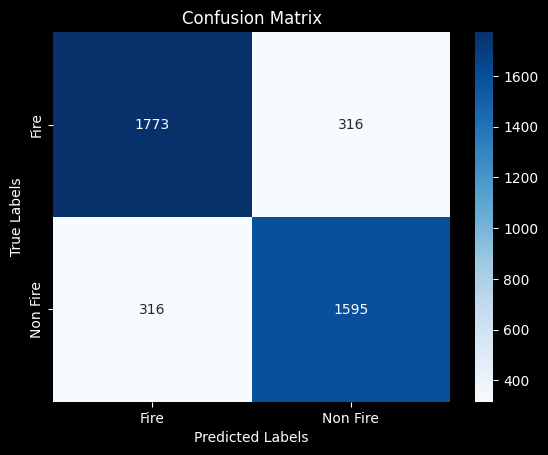

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(train_cm, annot=True, cmap="Blues", fmt="d")

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

class_labels = ["Fire", "Non Fire"]
ticks = np.arange(len(class_labels)) + 0.5
plt.xticks(ticks, class_labels)
plt.yticks(ticks, class_labels)
plt.show()

In [26]:
test_pred = best_model.predict(x_test)
print("\t\tTEST:\n")
print(f"Accuracy: {accuracy_score(y_test, test_pred)}\n")
print(f"Classification report: \n {classification_report(y_test, test_pred)}")
test_cm = confusion_matrix(y_test, test_pred)
print(f"Confusion matrix: \n {test_cm}")

		TEST:

Accuracy: 0.835

Classification report: 
               precision    recall  f1-score   support

           0       0.84      0.83      0.84       509
           1       0.83      0.84      0.83       491

    accuracy                           0.83      1000
   macro avg       0.83      0.84      0.83      1000
weighted avg       0.84      0.83      0.84      1000

Confusion matrix: 
 [[425  84]
 [ 81 410]]


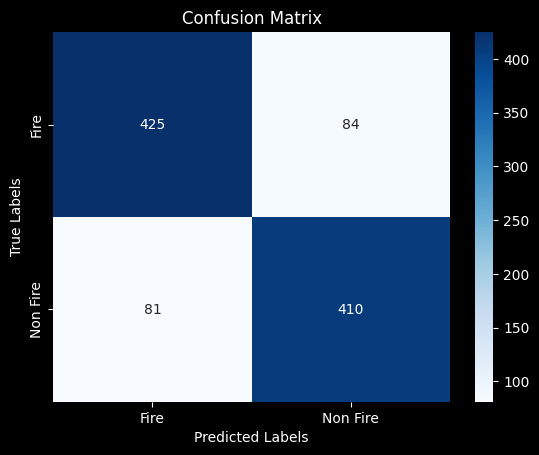

In [27]:
sns.heatmap(test_cm, annot=True, cmap="Blues", fmt="d")

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

class_labels = ["Fire", "Non Fire"]
ticks = np.arange(len(class_labels)) + 0.5
plt.xticks(ticks, class_labels)
plt.yticks(ticks, class_labels)
plt.show()

In [29]:
import pickle

file_name = "LGBMClassifier.pkl"
with open(file_name, "wb") as f:
    pickle.dump(best_model, f)